In [ ]:
# If running this in Google Colab remove the '#' in the line below & If prompted click the `RESTART RUNTIME` button below this cell
# !pip install berpublicsearch geopandas seaborn

# Download BERPublicsearch.zip, unzip & convert to parquet

In [ ]:
from berpublicsearch.download import download_berpublicsearch_parquet

# Register your email address with SEAI at https://ndber.seai.ie/BERResearchTool/Register/Register.aspx
email_address="EMAIL-ADDRESS"
download_berpublicsearch_parquet(email_address)

# Get Dublin BER Public Search data

In [24]:
import dask.dataframe as dd

ber_ireland = dd.read_parquet(data_dir / "BERPublicsearch_parquet")
ber_dublin = (
    ber_ireland[ber_ireland["CountyName"].str.contains("Dublin")]
    .loc[:, ["CountyName", "MainSpaceHeatingFuel", "MainWaterHeatingFuel"]]
    .compute()
)

# Get Postcodes boundaries linked to Local Authority 

In [20]:

import geopandas as gpd
from urllib.request import urlretrieve

dublin_postcode_boundaries_filepath = (
    data_dir / "dublin_postcode_boundaries_autoaddress.geojson"
)
if not dublin_postcode_boundaries_filepath.exists():
    urlretrieve(
        url="https://zenodo.org/record/4589220/files/dublin_postcode_boundaries_autoaddress.geojson",
        filename=dublin_postcode_boundaries_filepath,
    )

dublin_postcode_boundaries = gpd.read_file(dublin_postcode_boundaries_filepath, driver="GeoJSON")[["CountyName", "local_authority"]].drop_duplicates(subset=["CountyName"])
dublin_postcode_boundaries.iloc[0,1] = "Co. Dublin" # unlink Co. Dublin from any LA

# Link BER Public search to Local Authority

Keep `Co. Dublin` separate as spans 3 local authorities

In [25]:
ber_dublin_linked = ber_dublin.merge(dublin_postcode_boundaries)  

# Get Boiler Breakdown by Local Authority

In [4]:
from os import mkdir
from pathlib import Path
from shutil import rmtree

columns = ["local_authority", "MainSpaceHeatingFuel", "MainWaterHeatingFuel"]
for column_name in columns[1:]:
    dirpath = Path(column_name)
    try:
        mkdir(dirpath)
    except:
        rmtree(dirpath)
        mkdir(dirpath)

In [28]:
columns = ["local_authority", "MainSpaceHeatingFuel", "MainWaterHeatingFuel"]

In [31]:
for column_name in columns[1:]:
    for group_name, group in ber_dublin_linked[columns].groupby(columns[0]):
        savepath = Path(dirpath) / "{group_name}.csv"
        group[column_name].value_counts().to_csv(savepath)

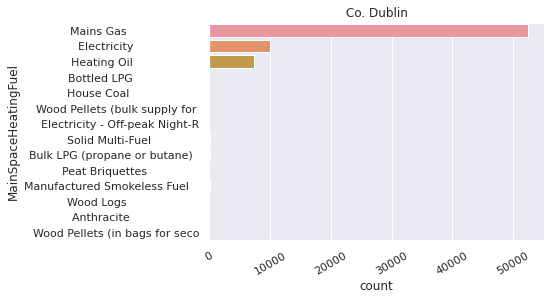

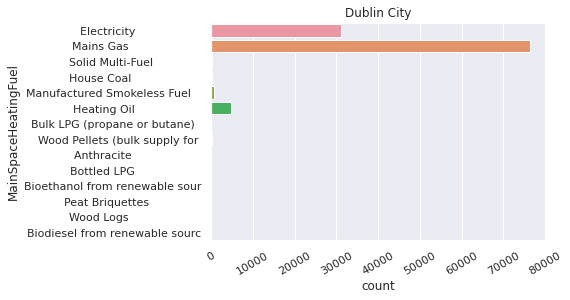

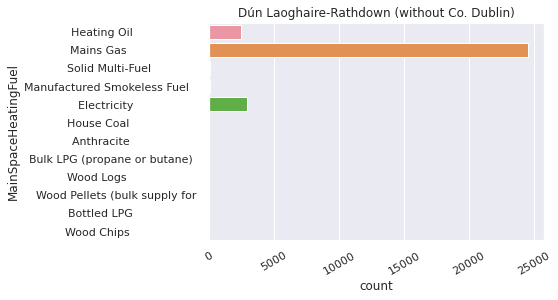

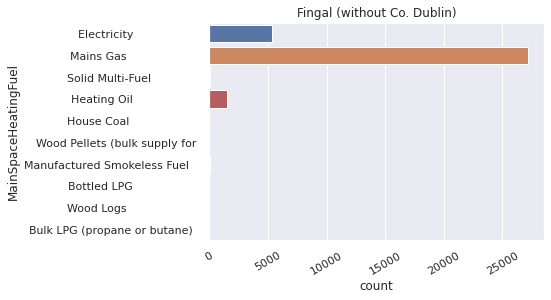

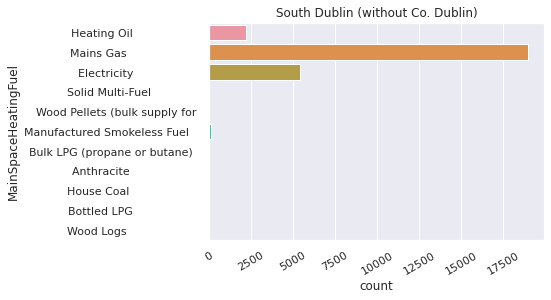

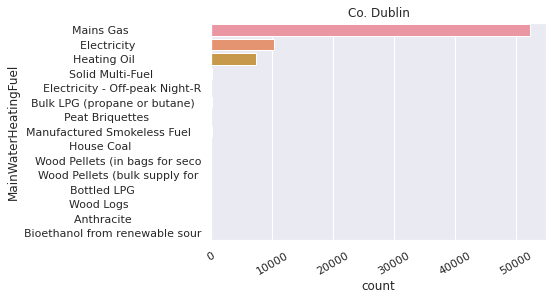

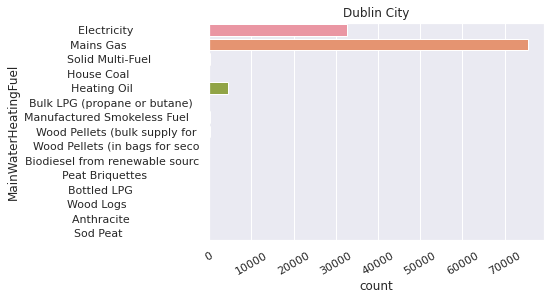

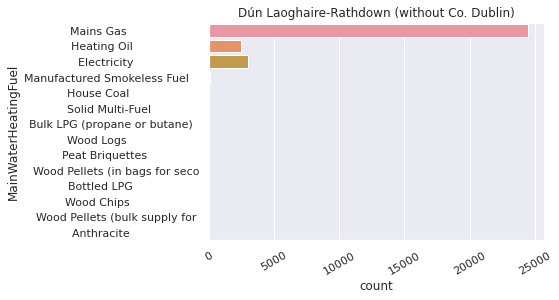

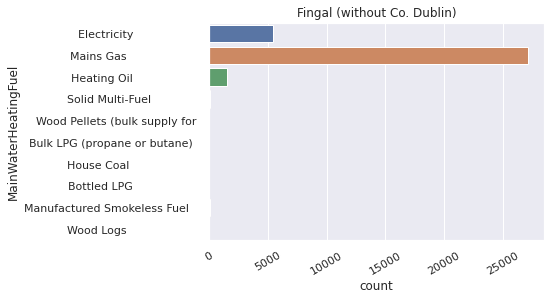

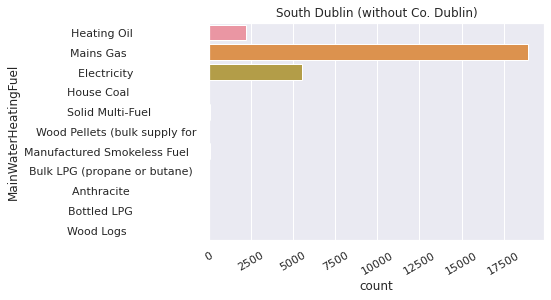

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

for column_name in columns[1:]:
    for group_name, group in ber_dublin_linked[columns].groupby(columns[0]):
        f, ax = plt.subplots()
        ax = sns.countplot(y=group[column_name])
        plt.setp(ax.get_xticklabels(), rotation=30)
        if group_name in ["Co. Dublin", "Dublin City"]:
            ax.set_title(group_name)
        else:
            ax.set_title(group_name + " (without Co. Dublin)")
        savepath = Path(column_name) / f"{group_name}.png"
        ax.figure.savefig(savepath)